<a href="https://colab.research.google.com/github/Rhqo/LLM_Study/blob/main/5_1_vqa_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-modal LLM - Visual question answering

In [1]:
!pip install openai -q
!pip install cohere -q
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.5/327.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.8/173.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 8.6 MB/s eta 0:00:00


In [20]:
import os
from openai import OpenAI
import cohere
import json
from transformers import pipeline

import requests
from PIL import Image
import matplotlib.pyplot as plt
import torch

from transformers import ViltForQuestionAnswering, ViltProcessor, BlipProcessor, BlipForQuestionAnswering, T5Tokenizer, T5ForConditionalGeneration
from google.colab import userdata

In [21]:
co = cohere.Client(userdata.get('CO_API_KEY'))

client = OpenAI(
    api_key=userdata.get('OPENAI_API_KEY')
)

In [27]:
def test_prompt_openai(prompt, suppress=False, model='gpt-3.5-turbo', **kwargs): # model=text-davinci-003

    if model in ('gpt-3.5-turbo', 'gpt-4'):
        response = client.chat.completions.create(
            model=model,
            messages=[{'role': 'user', 'content': prompt}]
        ).choices[0].message.content.strip()
        if not suppress:
            print(f'PROMPT:\n------\n{prompt}\n------\nRESPONSE\n------\n{prompt}\n{response}')


    else:
        response = client.chat.completions.create(
              model=model,
              prompt=prompt,
              max_tokens=256,
              **kwargs
            ).choices[0].text
        if not suppress:
            print(f'PROMPT:\n------\n{prompt}\n------\nRESPONSE\n------\n{prompt}{response}')
    return response

In [9]:
def test_prompt_cohere(prompt, suppress=False, model='command-xlarge-nightly', **kwargs):
    response = co.generate(
        model=model,
        prompt=prompt,
        max_tokens=256,
        **kwargs,
      ).generations[0].text
    if not suppress:
        print(f'PROMPT:\n------\n{prompt}\n------\nRESPONSE\n------\n{prompt}{response}')
    return response

# Using ViT and GPT2 to caption an incoming image
이미지 입력, ViT & GPT2 이용해서 이미지 캡션

In [10]:
image_to_text = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


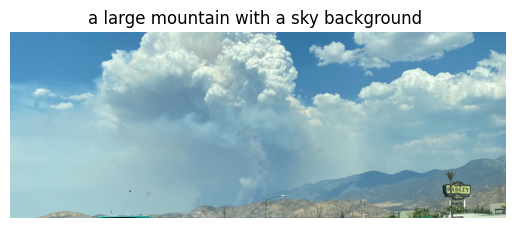

In [13]:
url = 'https://ethnomarginalia.com/wp-content/uploads/2021/10/smoke-picture-2.png?w=1600&h=600&crop=1'  # could also use a url here

caption = image_to_text(url)[0]['generated_text']
image = Image.open(requests.get(url, stream=True).raw if 'https' in url else url)

# display image with the generated caption and probability
plt.imshow(image)
plt.title(caption)
plt.axis('off')
plt.show()

In [14]:
caption

'a large mountain with a sky background '

In [15]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

# Using BART's MNLI to detect issue
MNLI 이용해서 issue detecting

In [30]:
candidate_labels = ["something happening outside", "something happening indoors", "potential electrical issue", "potential fire", "no safety issue"]

categories = classifier(caption, candidate_labels, multi_label=True)  # Assuming there can be multiple answers

THRESHOLD = 0.3

for label, score in zip(categories['labels'], categories['scores']):
    print(f'Label "{label}" has score {score*100:.2f}%')

categories_parsed = [(label, score) for label, score in zip(categories['labels'], categories['scores']) if score > THRESHOLD]

categories_parsed

Label "something happening outside" has score 95.76%
Label "no safety issue" has score 0.37%
Label "potential electrical issue" has score 0.08%
Label "potential fire" has score 0.05%
Label "something happening indoors" has score 0.02%


[('something happening outside', 0.9575516581535339)]

# Using OpenAI to detect issue
OpenAI 이용해서 issue detecting

In [35]:
categories = test_prompt_cohere(
    f'Given an image of {caption}. List all categories this image belongs in as a python list. '
    f'The only options are: ["outdoor", "indoor", "electrical_issue", "fire_issue", "no_issue"]',
    temperature=0
)

categories_parsed = json.loads(categories.replace("'", '"'))

categories_parsed

PROMPT:
------
Given an image of a large mountain with a sky background . List all categories this image belongs in as a python list. The only options are: ["outdoor", "indoor", "electrical_issue", "fire_issue", "no_issue"]
------
RESPONSE
------
Given an image of a large mountain with a sky background . List all categories this image belongs in as a python list. The only options are: ["outdoor", "indoor", "electrical_issue", "fire_issue", "no_issue"]['outdoor', 'no_issue']


['outdoor', 'no_issue']

# Using Cohere to detect issue & generate questions
Cohere 사용해서 issue detecting & 잠재적 위협 질문 생성

In [36]:
if 'no_issue' in categories_parsed or 'no safety issue' in categories_parsed:
    print('NO ISSUE DETECTED BUT TRYING AGAIN')
    # second chance to find an issue
    follow_up_questions = test_prompt_cohere(
        f'Your primary concern is understanding more about a potential active situation. '
        f'Given an image of {caption}, you want to understand if something might be wrong or someone might be in danger.'
        f'give a numbered list of 10 specific follow up questions that have to do with safety of the issue.'
    )
else:
    print('ISSUE DETECTED! Coming up with follow up questions')
    # understand more
    follow_up_questions = test_prompt_cohere(
    f'Your primary concern is safety and you want to understand more about an active situation. '
    f'Given an image of "{caption}" '
    f'give a numbered list of the 10 specific follow up questions about the image and the surroundings.'
)

NO ISSUE DETECTED BUT TRYING AGAIN
PROMPT:
------
Your primary concern is understanding more about a potential active situation. Given an image of a large mountain with a sky background , you want to understand if something might be wrong or someone might be in danger.give a numbered list of 10 specific follow up questions that have to do with safety of the issue.
------
RESPONSE
------
Your primary concern is understanding more about a potential active situation. Given an image of a large mountain with a sky background , you want to understand if something might be wrong or someone might be in danger.give a numbered list of 10 specific follow up questions that have to do with safety of the issue.1. Are there any climbers visible in the image, and if so, what are their positions relative to the mountain peaks or dangerous areas? 
2. Can you identify any potential hazards or risks in the image, such as loose rocks, avalanches, or signs of extreme weather conditions? 
3. Is there any cli

In [38]:
# Split the string into lines
lines = follow_up_questions.strip().split('\n')

# Extract the numbered list as a Python list
numbered_list = []
for line in lines:
    if line and line[0].isdigit() and len(line) > 3:
        numbered_list.append(line.split('. ')[1])

# Print the resulting list
for line in numbered_list:
    print(line)
#print(numbered_list)

Are there any climbers visible in the image, and if so, what are their positions relative to the mountain peaks or dangerous areas? 
Can you identify any potential hazards or risks in the image, such as loose rocks, avalanches, or signs of extreme weather conditions? 
Is there any climbing equipment visible, and is it being used properly and safely? 
Are there any visible signs of distress or emergency signals from anyone in the image? 
What are the lighting conditions in the image? Is it daytime, dusk, or night, and are there any signs of flashlights or emergency lighting being used? 
Can you estimate the scale and height of the mountain from the image, and is it a dangerous altitude for climbers? 
Are there any visible trails or paths that climbers might be using, and do they appear safe and well-maintained? 
Is there any signage in the image that might indicate potential dangers or provide safety instructions? 
Are there any visible rescue or emergency response teams in the image, a

# Using Vilt to answer follow up questions
Vilt 이용해서 질문에 대한 응답

In [39]:
vilt_processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
vilt_model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/136k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/470M [00:00<?, ?B/s]

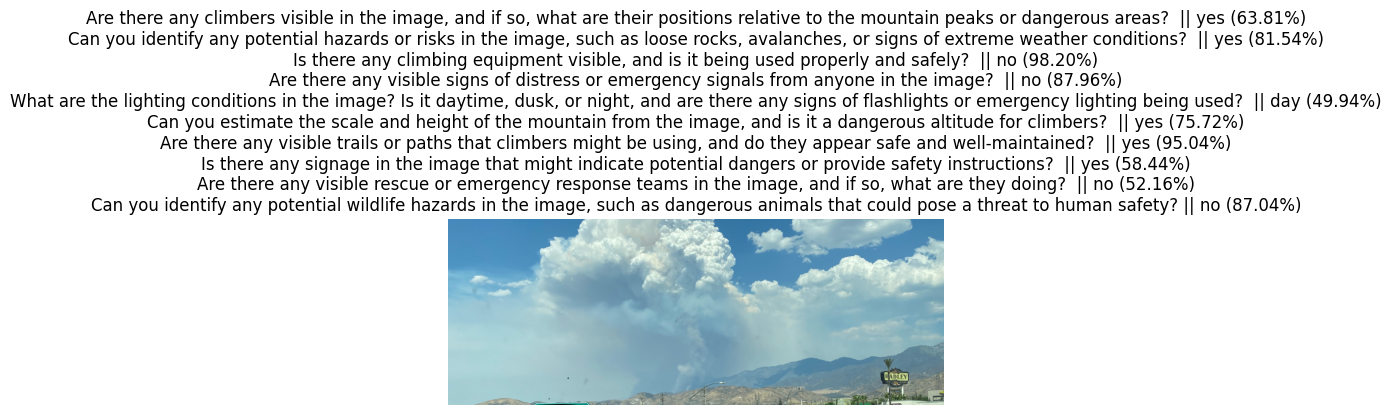

In [40]:
title = ''

for follow_up_question in numbered_list:

    # prepare inputs
    encoding = vilt_processor(image, follow_up_question, return_tensors="pt")

    # forward pass
    outputs = vilt_model(**encoding)
    logits = outputs.logits
    idx = logits.argmax(-1).item()

    # apply softmax to get probabilities
    probabilities = torch.softmax(logits, dim=-1)
    predicted_probability = probabilities[0, idx].item()

    predicted_answer = vilt_model.config.id2label[idx]
    title += f"{follow_up_question} || {predicted_answer} ({predicted_probability:.2%})\n"

# display image with the generated caption and probability
plt.imshow(image)
plt.title(title.strip())
plt.axis('off')
plt.show()

In [41]:
print(title)

Are there any climbers visible in the image, and if so, what are their positions relative to the mountain peaks or dangerous areas?  || yes (63.81%)
Can you identify any potential hazards or risks in the image, such as loose rocks, avalanches, or signs of extreme weather conditions?  || yes (81.54%)
Is there any climbing equipment visible, and is it being used properly and safely?  || no (98.20%)
Are there any visible signs of distress or emergency signals from anyone in the image?  || no (87.96%)
What are the lighting conditions in the image? Is it daytime, dusk, or night, and are there any signs of flashlights or emergency lighting being used?  || day (49.94%)
Can you estimate the scale and height of the mountain from the image, and is it a dangerous altitude for climbers?  || yes (75.72%)
Are there any visible trails or paths that climbers might be using, and do they appear safe and well-maintained?  || yes (95.04%)
Is there any signage in the image that might indicate potential dan